In [ ]:
import tensorflow as tf

print("Available GPU device:", tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Success")
    except RuntimeError as e:
        print("Error:", e)

Available GPU device: []


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

In [ ]:
df = pd.read_csv('csic_database.csv')

In [ ]:
features = ['Method', 'URL', 'Accept', 'content']
# keep non-null data
for feature in features:
    if feature in df.columns:
        df = df[df[feature].notna()]

In [ ]:
def combine_features(row):
    combined = f"{row['Method']} {row['URL']} "
    if pd.notna(row['User-Agent']):
        combined += row['User-Agent']
    if pd.notna(row['content']) and row['content'] != '':
        combined += f" {row['content']}"
    return combined

df['combined_features'] = df.apply(combine_features, axis=1)

In [ ]:
# create tokenizer
max_features = 10000  # vocabulary size
tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(df['combined_features'])

# transmit text to digital sequence
X_sequences = tokenizer.texts_to_sequences(df['combined_features'])

# padding sequence
max_len = 100  # Maximum sequence length
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')

y = df['classification'].values

In [ ]:
X_sequences

[[9,
  5,
  10,
  11,
  12,
  20,
  45,
  13,
  5,
  3,
  3,
  14,
  2,
  8,
  15,
  16,
  4,
  2,
  17,
  18,
  4,
  2,
  6,
  7,
  19,
  40,
  4,
  23,
  80,
  77,
  38,
  82,
  52,
  507,
  21,
  43,
  51,
  46,
  39],
 [9,
  5,
  10,
  11,
  12,
  20,
  49,
  13,
  5,
  3,
  3,
  14,
  2,
  8,
  15,
  16,
  4,
  2,
  17,
  18,
  4,
  2,
  6,
  7,
  19,
  22,
  26,
  25,
  1,
  54,
  1,
  65,
  53,
  71,
  21,
  26],
 [9,
  5,
  10,
  11,
  12,
  20,
  57,
  13,
  5,
  3,
  3,
  14,
  2,
  8,
  15,
  16,
  4,
  2,
  17,
  18,
  4,
  2,
  6,
  7,
  19,
  40,
  58],
 [9,
  5,
  10,
  11,
  12,
  20,
  26,
  13,
  5,
  3,
  3,
  14,
  2,
  8,
  15,
  16,
  4,
  2,
  17,
  18,
  4,
  2,
  6,
  7,
  19,
  64,
  59,
  60],
 [9,
  5,
  10,
  11,
  12,
  20,
  50,
  13,
  5,
  3,
  3,
  14,
  2,
  8,
  15,
  16,
  4,
  2,
  17,
  18,
  4,
  2,
  6,
  7,
  19,
  22,
  55,
  38,
  1,
  21,
  69,
  70,
  72],
 [9,
  5,
  10,
  11,
  12,
  20,
  24,
  13,
  5,
  3,
  3,
  14,
  2,
  8,
  15,
  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 162s 819ms/step - accuracy: 0.6180 - loss: 0.6138 - val_accuracy: 0.9296 - val_loss: 0.2087
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 809ms/step - accuracy: 0.9338 - loss: 0.2215 - val_accuracy: 0.9609 - val_loss: 0.1328
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 806ms/step - accuracy: 0.9701 - loss: 0.1259 - val_accuracy: 0.9609 - val_loss: 0.1281
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 808ms/step - accuracy: 0.9794 - loss: 0.0943 - val_accuracy: 0.9680 - val_loss: 0.1294
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 809ms/step - accuracy: 0.9855 - loss: 0.0681 - val_accuracy: 0.9684 - val_loss: 0.1358
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 141s 804ms/step - accuracy: 0.9873 - loss: 0.0582 - val_accuracy: 0.9698 - val_loss: 0.1395


110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.9608 - loss: 0.1363
测试集准确率: 96.22%


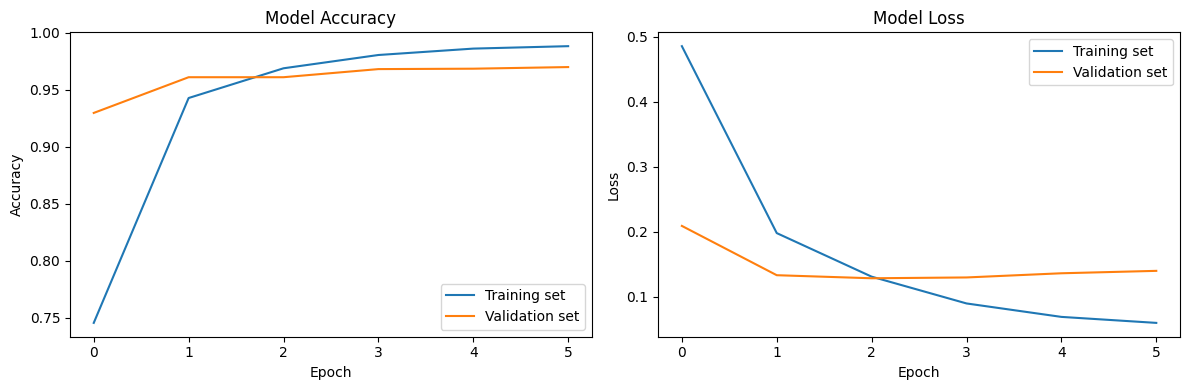

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test set Accuracy: {accuracy*100:.2f}%")

# Visulization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step


<Axes: title={'center': 'LSTM'}>

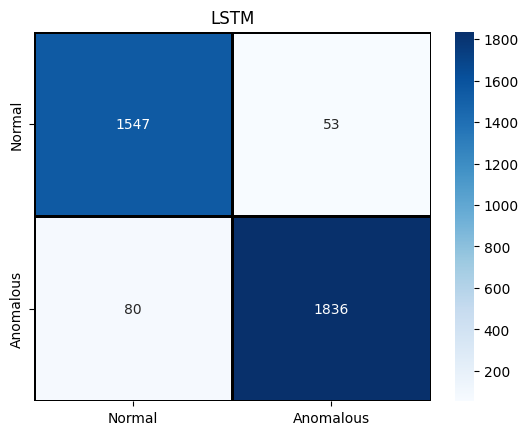

In [ ]:
label = ['Normal', 'Anomalous']
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.title("LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = label, yticklabels = label)

In [ ]:
print('MAE', mean_absolute_error(y_test, y_pred))
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
print("Recall", recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
print("F1", f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
print("ROC AUC", roc_auc_score(y_test,y_pred, average='weighted', labels=np.unique(y_pred)))


MAE 0.03782707622298066
Accuracy 0.9621729237770194
Precision 0.9623350549289056
Recall 0.9621729237770194
F1 0.9621969624646992
ROC AUC 0.9625606732776617
